## Change sys.path to use my tensortrade instead of the one in env

In [1]:
import sys
import os
# sys.path.append("/Users/jasonfiacco/Documents/Yale/Senior/thesis/deeptrader")
# sys.path.append("/Users/jasonfiacco/Documents/Yale/Senior/thesis/deeptrader/GetOldTweets")
sys.path.append(os.path.realpath(".."))
sys.path.append(os.path.realpath("../GetOldTweets"))
print(sys.path)

['/home/accts/jcf73/thesis/deeptrader/examples', '/home/accts/jcf73/thesis/venv/lib64/python37.zip', '/home/accts/jcf73/thesis/venv/lib64/python3.7', '/home/accts/jcf73/thesis/venv/lib64/python3.7/lib-dynload', '/usr/lib64/python3.7', '/usr/lib/python3.7', '', '/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages', '/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/IPython/extensions', '/home/accts/jcf73/.ipython', '/home/accts/jcf73/thesis/deeptrader', '/home/accts/jcf73/thesis/deeptrader/GetOldTweets']


## Fetch the Labeled PredictIt Data  
Adds ALL TA features at first. Also creates the "price_norm" metric which is close/open.

In [2]:
import ssl
import pandas as pd
import ta
from datetime import datetime, timedelta

ssl._create_default_https_context = ssl._create_unverified_context # Only used if pandas gives a SSLError

def fetch_data(symbol):
    path = "../predictit_datasets/"
    filename = "{}_labeled.csv".format(symbol)

    df = pd.read_csv(path + filename)
    
    df = df.set_index("Date")


    return df

In [3]:
all_data = pd.concat([
    fetch_data("WARREN"),
    fetch_data("CRUZ"),
], axis=1)
all_data.head()

,WARREN:open,WARREN:low,WARREN:high,WARREN:close,WARREN:volume,WARREN:average,WARREN:price_norm,WARREN:current_date,WARREN:sentiment,WARREN:volume_adi,...,CRUZ:momentum_uo,CRUZ:momentum_stoch,CRUZ:momentum_stoch_signal,CRUZ:momentum_wr,CRUZ:momentum_ao,CRUZ:momentum_kama,CRUZ:momentum_roc,CRUZ:others_dr,CRUZ:others_dlr,CRUZ:others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.81,0.79,0.82,0.80,768,0.8067,0.987654,2017-02-01,0.04693,-256.0,...,NaN,14.285714,14.285714,-85.714286,0.0,NaN,NaN,6.111002,NaN,0.000000
2017-02-02,0.80,0.79,0.80,0.79,50,0.7996,0.987500,2017-02-02,0.05167,-306.0,...,NaN,0.000000,7.142857,-100.000000,0.0,NaN,NaN,-3.703704,-3.774033,-3.703704
2017-02-03,0.79,0.78,0.80,0.78,592,0.7813,0.987342,2017-02-03,0.07868,-898.0,...,NaN,33.333333,15.873016,-66.666667,0.0,NaN,NaN,3.846154,3.774033,0.000000
2017-02-04,0.78,0.78,0.79,0.79,10,0.7900,1.012821,2017-02-04,0.14822,-888.0,...,NaN,33.333333,22.222222,-66.666667,0.0,NaN,NaN,0.000000,0.000000,0.000000
2017-02-05,0.79,0.79,0.80,0.80,6,0.7950,1.012658,2017-02-05,-0.01526,-882.0,...,NaN,33.333333,33.333333,-66.666667,0.0,NaN,NaN,0.000000,0.000000,0.000000


## Plot the closing prices for all the markets

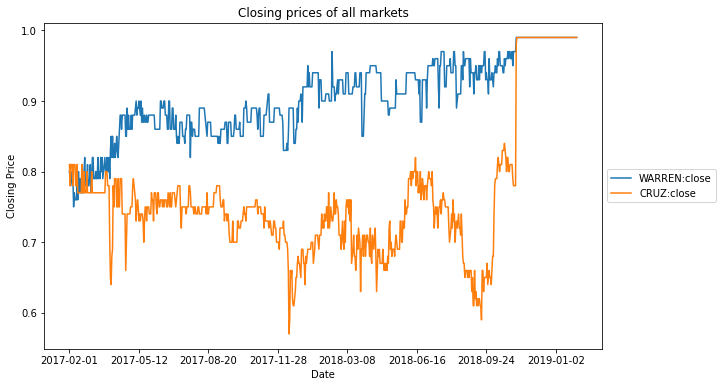

In [4]:
import matplotlib.pyplot as plt
closing_prices = all_data.loc[:, [("close" in name) for name in all_data.columns]]
closing_prices.plot(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing prices of all markets")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

In [5]:
#Copy it over cause of variable names
subset_data = all_data

## Define The Exchange

An exchange needs a name, an execution service, and streams of price data in order to function properly.

The setups supported right now are the simulated execution service using simulated or stochastic data. More execution services will be made available in the future, as well as price streams so that live data and execution can be supported.

In [6]:
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream

#Exchange(name of exchange, service)
#It looks like each Stream takes a name, and then a list of the closing prices.

predictit_exch = Exchange("predictit", service=execute_order)(
    Stream("USD-WARREN", list(subset_data['WARREN:close'])),
    Stream("USD-CRUZ", list(subset_data['CRUZ:close'])),
)

Now that the exchanges have been defined we can define our features that we would like to include, excluding the prices we have provided for the exchanges.

## Defint the "Portfolio"

Make the portfolio using the any combinations of exchanges and intruments that the exchange supports

In [7]:
#I am going to have to add "instruments" for all 25 of the PredictIt markets I'm working with.
from tensortrade.instruments import USD, WARREN, CRUZ, MANCHIN, SANDERS, NELSON, DONNELLY,\
                                PELOSI, MANAFORT, BROWN, RYAN, STABENOW, KNIGHT, MCCASKILL, \
                                BALDWIN, DENHAM, HEITKAMP, TESTER, HURD, HEINRICH, MENENDEZ
from tensortrade.wallets import Wallet, Portfolio

portfolio = Portfolio(USD, [
    Wallet(predictit_exch, 100000 * USD),
    Wallet(predictit_exch, 100 * WARREN),
    Wallet(predictit_exch, 100 * CRUZ)
])

## Create a feature dataframe that specifies custom features

In [8]:
#Select only the TA features to keep
features_to_keep = ["close"]
feature_data = subset_data.loc[:, [(any(word in name for word in features_to_keep)) for name in subset_data.columns]]

#Remove any extra volume columns
feature_data = feature_data[feature_data.columns.drop(list(feature_data.filter(regex='volume_')))]

feature_data.head(5)

,WARREN:close,CRUZ:close
Date,,
2017-02-01,0.80,0.81
2017-02-02,0.79,0.78
2017-02-03,0.78,0.81
2017-02-04,0.79,0.81
2017-02-05,0.80,0.81


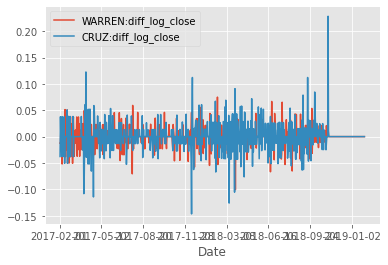

In [9]:
import numpy as np
feature_data["WARREN:diff_log_close"] = np.log(feature_data["WARREN:close"]) - np.log(feature_data["WARREN:close"].shift(1))
feature_data["CRUZ:diff_log_close"] = np.log(feature_data["CRUZ:close"]) - np.log(feature_data["CRUZ:close"].shift(1))
feature_data.drop(['WARREN:close', "CRUZ:close"], axis=1, inplace=True)
feature_data.plot()


In [10]:
#Add tomorrow's price
feature_data["WARREN:close_tomorrow"] = feature_data["WARREN:diff_log_close"].shift(1)
feature_data["CRUZ:close_tomorrow"] = feature_data["CRUZ:diff_log_close"].shift(1)
#Replace all inf and -inf (which are in the trend_cci column) with Nan
import numpy as np
feature_data = feature_data.replace([np.inf, -np.inf, np.nan], 0)
feature_data.head(5)

,WARREN:diff_log_close,CRUZ:diff_log_close,WARREN:close_tomorrow,CRUZ:close_tomorrow
Date,,,,
2017-02-01,0.000000,0.00000,0.000000,0.00000
2017-02-02,-0.012579,-0.03774,0.000000,0.00000
2017-02-03,-0.012739,0.03774,-0.012579,-0.03774
2017-02-04,0.012739,0.00000,-0.012739,0.03774
2017-02-05,0.012579,0.00000,0.012739,0.00000


### Now make the "External Data Feed" objects

In [11]:
#Add "Streams" for all my external added features.
from tensortrade.data import DataFeed, Module

#Do it for train set
with Module("predictit") as predictit_ns:
    predictit_nodes = [Stream(name, list(feature_data[name])) for name in feature_data.columns]

In [12]:
#Then create the train Feed from it
external_feed = DataFeed([predictit_ns])
external_feed.next()

{'predictit:/WARREN:diff_log_close': 0.0,
 'predictit:/CRUZ:diff_log_close': 0.0,
 'predictit:/WARREN:close_tomorrow': 0.0,
 'predictit:/CRUZ:close_tomorrow': 0.0}

## First Launch Ray. 
This is where you define our training "Trading Enviroment," which includes things such as the action scheme, the reward scheme, the window size, and whether or not to use the "interal feed" (internal data feed has all the price data from the wallets and the networth of the portfolio).

In [13]:
#Add the deeptrader path to ALL workers, not just the current worker
import os
parent_dir = os.path.realpath("..")
os.environ["PYTHONPATH"] = parent_dir + ":" + os.environ.get("PYTHONPATH", "")

In [14]:
#Try and get rid of that yaml warning (although this only does it for THIS worker)
import yaml
yaml.warnings({'YAMLLoadWarning': False})

In [15]:
# Environment
from tensortrade.environments import TradingEnvironment


import gym
import ray
from ray import tune
from ray.tune import grid_search
from ray.tune.registry import register_env

import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print
from tensortrade.rewards import RiskAdjustedReturns
    
class RayTradingEnv(TradingEnvironment):
    def __init__(self):        
        env = TradingEnvironment(
            feed=external_feed,
            portfolio=portfolio,
            action_scheme="simple",
            reward_scheme="diversified",
            window_size=15,
            enable_logger=False,
            renderers = 'screenlog',
            #use_internal = True,
        ) 
        self.env = env
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        
        

    def reset(self):
        return self.env.reset()

    def step(self, action):
        return self.env.step(action)

def env_creator(env_config):
    return RayTradingEnv()

register_env("ray_trading_env", env_creator)


#ray.init(ignore_reinit_error=True, local_mode=True)

## Train using Tune

In [16]:
#Implement Custom neural network model
from ray.rllib.models import ModelCatalog
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.agents.dqn.distributional_q_model import DistributionalQModel
from ray.rllib.utils import try_import_tf

tf = try_import_tf()

class CNNModel(DistributionalQModel):
    """Custom model for DQN."""

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name, **kw):
        super(CNNModel, self).__init__(
            obs_space, action_space, num_outputs, model_config, name, **kw)

        # Define neural net layers
        self.base_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=obs_space.shape),
            tf.keras.layers.Conv1D(filters=40, kernel_size=6, padding="same", activation="relu"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(filters=20, kernel_size=3, padding="same", activation="relu"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_outputs, activation="softmax")
        ])
        
        self.register_variables(self.base_model.variables)

    # Implement the core forward method
    def forward(self, input_dict, state, seq_lens):
        model_out = self.base_model(input_dict["obs"])
        return model_out, state
    
ModelCatalog.register_custom_model("cnn_model", CNNModel)

In [17]:
# Population based training
from ray.tune.schedulers import PopulationBasedTraining
import random

pbt = PopulationBasedTraining(
    time_attr="time_total_s",
    metric="episode_reward_mean",
    mode="max",
    perturbation_interval=240, #Every 10,000 steps, consider changing learning rate
    hyperparam_mutations={
        "lr": lambda: random.uniform(.00001, .1),
        #"epsilon_timesteps": lambda: random.uniform(10000, 100000)
        #"train_batch_size": lambda: random.uniform(10, 1000),
    } 
)

In [ ]:
analysis = tune.run(
        "DQN",
        name = "DQN53-mini",
        #restore = "/home/accts/jcf73/ray_results/DQN53-mini/DQN_ray_trading_env_da36079e_0_2020-04-10_15-17-00m1kzpf5o/checkpoint_150/checkpoint-150",
        #scheduler=pbt, #Use Population Based Training
        #num_samples=3, #Number of different hyperparameters to sample
        #reuse_actors=True,
        checkpoint_freq = 50,
        checkpoint_at_end=True,
        stop={
            "timesteps_total": 10000000,
        },
        config={
            "env": "ray_trading_env",
            "lr": .00001,  # try different lrs
            "num_workers": 18,  # parallelism,
            #"eager": "true",
            #"model": {
            #    "custom_model": "cnn_model"
            #},
            "exploration_config": {
                "initial_epsilon": 0.85,
                "epsilon_timesteps": 3000000,
                
            },
            "train_batch_size": 100,
            #"clip_rewards": True,
            #"grad_norm_clipping": None,
            "target_network_update_freq": 2000,
        },
        
    )

2020-04-10 15:46:22,049	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-10 15:46:22,058	INFO resource_spec.py:212 -- Starting Ray with 36.18 GiB memory available for workers and up to 18.11 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-10 15:46:22,604	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


Trial name,status,loc
DQN_ray_trading_env_f4dd87b2,RUNNING,


(pid=6769) 2020-04-10 15:46:30,253	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
(pid=6769) 2020-04-10 15:46:32,122	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=6769) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=6769)   obj = yaml.load(type_)
(pid=6769) 2020-04-10 15:46:33,709	WARNING util.py:37 -- Install gputil for GPU system monitoring.
(pid=6776) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=6776)   obj = yaml

Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-46-47
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    - 0.8500000238418579
    grad_time_ms: .nan
    learner: {}
    num_steps_sampled: 1008
    num_steps_trained: 0
    num_target_updates: 0
    opt_peak_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,nan,14.0192,1008,1


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-46-56
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    - 0.8497211337089539
    grad_time_ms: 12.076
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 1.5238962173461914

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,nan,22.7428,3024,3


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-47-07
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    - 0.8491633534431458
    grad_time_ms: 12.423
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 2.0220375061035156

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,nan,33.3726,5040,5


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-47-13
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    - 0.8488844633102417
    grad_time_ms: 12.253
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 2.219066619873047


Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,nan,39.3515,6048,6


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-47-19
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    - 0.8486055731773376
    grad_time_ms: 12.368
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 2.467582941055298


Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,nan,46.0501,7056,7


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-47-27
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    - 0.8483267426490784
    grad_time_ms: 12.205
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 2.5726842880249023

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,nan,53.1995,8064,8


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-47-34
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    - 0.8480478525161743
    grad_time_ms: 12.19
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 2.688826560974121
 

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,nan,60.9245,9072,9


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-47-43
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    - 0.8477689623832703
    grad_time_ms: 12.353
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 3.313868999481201


Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,nan,69.6281,10080,10


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-47-53
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    - 0.8474900722503662
    grad_time_ms: 12.44
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 3.4141249656677246


Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,nan,79.3552,11088,11


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-48-02
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    - 0.8472111821174622
    grad_time_ms: 12.44
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 4.104831695556641
 

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,nan,88.8725,12096,12


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-48-12
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    - 0.8469322919845581
    grad_time_ms: 12.153
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
        max_q: 3.8835902214050293

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,nan,98.8213,13104,13


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-48-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.10854118132238333
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    - 0.8463745713233948
    grad_time_ms: 12.852
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.108541,106.311,15120,15


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-48-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.10854118132238333
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    - 0.8458167910575867
    grad_time_ms: 12.112
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.108541,115.942,17136,17


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-48-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.10854118132238333
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    - 0.8455379009246826
    grad_time_ms: 12.34
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.108541,121.552,18144,18


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-48-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.10854118132238333
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    - 0.8452590107917786
    grad_time_ms: 12.28
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.108541,127.529,19152,19


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-48-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.10854118132238333
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    - 0.8449801802635193
    grad_time_ms: 12.325
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.108541,134.394,20160,20


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-48-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.10854118132238333
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    - 0.8447012901306152
    grad_time_ms: 12.453
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.108541,141.676,21168,21


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-49-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.10854118132238333
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    - 0.8444223999977112
    grad_time_ms: 12.511
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.108541,149.465,22176,22


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-49-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.10854118132238333
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    - 0.8441435098648071
    grad_time_ms: 12.381
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.108541,158.063,23184,23


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-49-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.10854118132238333
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    - 0.8438646197319031
    grad_time_ms: 12.132
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.108541,166.938,24192,24


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-49-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.10854118132238333
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    - 0.8435857892036438
    grad_time_ms: 12.504
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.108541,176.475,25200,25


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-49-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.10854118132238333
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 18
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    - 0.8433068990707397
    grad_time_ms: 12.277
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.108541,186.695,26208,26


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-49-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.14848105785217441
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    - 0.8427491188049316
    grad_time_ms: 12.562
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148481,194.152,28224,28


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-49-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.14848105785217441
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    - 0.8421913385391235
    grad_time_ms: 12.383
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148481,203.769,30240,30


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-50-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.14848105785217441
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    - 0.8419125080108643
    grad_time_ms: 12.306
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148481,209.562,31248,31


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-50-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.14848105785217441
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    - 0.8416336178779602
    grad_time_ms: 12.421
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148481,215.735,32256,32


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-50-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.14848105785217441
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    - 0.8413547277450562
    grad_time_ms: 12.088
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148481,222.477,33264,33


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-50-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.14848105785217441
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    - 0.8410758376121521
    grad_time_ms: 12.067
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148481,229.749,34272,34


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-50-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.14848105785217441
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    - 0.840796947479248
    grad_time_ms: 12.18
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148481,237.511,35280,35


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-50-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.14848105785217441
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    - 0.840518057346344
    grad_time_ms: 12.402
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148481,246.209,36288,36


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-50-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.14848105785217441
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    - 0.8402392268180847
    grad_time_ms: 12.517
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148481,255.178,37296,37


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-50-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.14848105785217441
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    - 0.8399603366851807
    grad_time_ms: 12.553
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148481,264.882,38304,38


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-51-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.14848105785217441
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    - 0.8396814465522766
    grad_time_ms: 12.237
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148481,275.043,39312,39


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-51-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.13884322565063886
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    - 0.8391236662864685
    grad_time_ms: 12.466
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138843,282.928,41328,41


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-51-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.13884322565063886
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    - 0.8385659456253052
    grad_time_ms: 12.472
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138843,292.646,43344,43


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-51-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.13884322565063886
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    - 0.8382870554924011
    grad_time_ms: 12.525
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138843,298.326,44352,44


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-51-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.13884322565063886
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    - 0.8380081653594971
    grad_time_ms: 12.597
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138843,304.762,45360,45


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-51-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.13884322565063886
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    - 0.837729275226593
    grad_time_ms: 12.661
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138843,312.236,46368,46


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-51-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.13884322565063886
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    - 0.837450385093689
    grad_time_ms: 12.417
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138843,320.009,47376,47


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-52-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.13884322565063886
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    - 0.8371714949607849
    grad_time_ms: 12.437
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138843,327.872,48384,48


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-52-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.13884322565063886
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    - 0.8368926644325256
    grad_time_ms: 12.739
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138843,336.518,49392,49


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-52-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.13884322565063886
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    - 0.8366137742996216
    grad_time_ms: 12.584
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138843,345.477,50400,50


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-52-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.13884322565063886
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    - 0.8363348841667175
    grad_time_ms: 12.786
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138843,355.096,51408,51


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-52-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.13884322565063886
  episode_reward_min: -0.30757341516816716
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    - 0.8360559940338135
    grad_time_ms: 12.71
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138843,365.246,52416,52


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-52-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.12257408197879023
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    - 0.8354982137680054
    grad_time_ms: 13.446
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.122574,373.385,54432,54


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-52-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.12257408197879023
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    - 0.834940493106842
    grad_time_ms: 12.533
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.122574,383.053,56448,56


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-53-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.12257408197879023
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    - 0.834661602973938
    grad_time_ms: 12.243
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.122574,388.583,57456,57


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-53-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.12257408197879023
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    - 0.8343827128410339
    grad_time_ms: 12.537
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.122574,394.972,58464,58


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-53-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.12257408197879023
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    - 0.8341038227081299
    grad_time_ms: 12.367
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.122574,401.793,59472,59


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-53-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.12257408197879023
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    - 0.8338249325752258
    grad_time_ms: 12.701
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.122574,409.139,60480,60


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-53-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.12257408197879023
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    - 0.8335461020469666
    grad_time_ms: 12.596
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.122574,417.155,61488,61


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-53-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.12257408197879023
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    - 0.8332672119140625
    grad_time_ms: 12.635
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.122574,425.735,62496,62


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-53-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.12257408197879023
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    - 0.8329883217811584
    grad_time_ms: 12.379
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.122574,434.731,63504,63


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-54-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.12257408197879023
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    - 0.8327094316482544
    grad_time_ms: 12.831
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.122574,444.557,64512,64


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-54-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5776936346291227
  episode_reward_mean: 0.12257408197879023
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 72
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    - 0.8324305415153503
    grad_time_ms: 12.616
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.122574,454.858,65520,65


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-54-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.1263681193264169
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    - 0.831872820854187
    grad_time_ms: 12.806
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126368,463.439,67536,67


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-54-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.1263681193264169
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    - 0.8313150405883789
    grad_time_ms: 12.512
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126368,473.125,69552,69


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-54-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.1263681193264169
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    - 0.8310361504554749
    grad_time_ms: 12.554
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126368,478.881,70560,70


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-54-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.1263681193264169
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    - 0.8307572603225708
    grad_time_ms: 12.652
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126368,485.109,71568,71


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-54-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.1263681193264169
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    - 0.8304784297943115
    grad_time_ms: 12.559
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126368,491.888,72576,72


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-54-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.1263681193264169
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    - 0.8301995396614075
    grad_time_ms: 12.749
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126368,499.444,73584,73


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-55-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.1263681193264169
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    - 0.8299206495285034
    grad_time_ms: 12.678
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126368,507.604,74592,74


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-55-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.1263681193264169
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    - 0.8296417593955994
    grad_time_ms: 12.574
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126368,516.345,75600,75


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-55-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.1263681193264169
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    - 0.8293628692626953
    grad_time_ms: 12.562
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126368,525.581,76608,76


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-55-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.1263681193264169
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    - 0.8290839791297913
    grad_time_ms: 12.669
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126368,535.325,77616,77


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-55-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.1263681193264169
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    - 0.828805148601532
    grad_time_ms: 12.817
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126368,545.744,78624,78


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-55-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.13335038687860123
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    - 0.8282473683357239
    grad_time_ms: 12.745
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.13335,554.123,80640,80


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-56-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.13335038687860123
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    - 0.8276895880699158
    grad_time_ms: 12.665
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.13335,564.059,82656,82


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-56-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.13335038687860123
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    - 0.8274106979370117
    grad_time_ms: 12.47
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.13335,570.401,83664,83


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-56-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.13335038687860123
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    - 0.8271318674087524
    grad_time_ms: 12.363
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.13335,577.171,84672,84


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-56-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.13335038687860123
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    - 0.8268529772758484
    grad_time_ms: 12.159
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.13335,584.004,85680,85


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-56-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.13335038687860123
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    - 0.8265740871429443
    grad_time_ms: 12.619
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.13335,591.594,86688,86


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-56-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.13335038687860123
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    - 0.8262951970100403
    grad_time_ms: 12.371
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.13335,599.425,87696,87


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-56-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.13335038687860123
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    - 0.8260163068771362
    grad_time_ms: 13.217
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.13335,608.026,88704,88


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-56-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.13335038687860123
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    - 0.8257374167442322
    grad_time_ms: 12.667
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.13335,617.26,89712,89


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-57-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.13335038687860123
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    - 0.8254585862159729
    grad_time_ms: 12.831
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.13335,627.03,90720,90


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-57-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.13335038687860123
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    - 0.8251796960830688
    grad_time_ms: 12.67
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.13335,637.243,91728,91


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-57-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.14684417620880155
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 18
  episodes_total: 126
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    - 0.8249008059501648
    grad_time_ms: 12.552
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.146844,642.325,92736,92


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-57-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.14684417620880155
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    - 0.8243430256843567
    grad_time_ms: 12.267
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.146844,650.755,94752,94


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-57-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.14684417620880155
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    - 0.8240641355514526
    grad_time_ms: 12.681
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.146844,655.79,95760,95


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-57-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.14684417620880155
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    - 0.8237853050231934
    grad_time_ms: 12.639
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.146844,661.535,96768,96


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-57-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.14684417620880155
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    - 0.8235064148902893
    grad_time_ms: 12.712
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.146844,667.715,97776,97


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-57-51
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.14684417620880155
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    - 0.8232275247573853
    grad_time_ms: 12.321
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.146844,674.642,98784,98


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-57-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.14684417620880155
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    - 0.8229486346244812
    grad_time_ms: 12.695
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.146844,682.158,99792,99


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-58-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.14684417620880155
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    - 0.8226697444915771
    grad_time_ms: 12.641
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.146844,690.115,100800,100


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-58-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.14684417620880155
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    - 0.8223908543586731
    grad_time_ms: 12.592
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.146844,698.65,101808,101


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-58-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.14684417620880155
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    - 0.8221120238304138
    grad_time_ms: 12.471
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.146844,707.83,102816,102


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-58-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.14684417620880155
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    - 0.8218331336975098
    grad_time_ms: 12.574
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.146844,717.68,103824,103


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-58-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5805689600807461
  episode_reward_mean: 0.14684417620880155
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 126
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    - 0.8215542435646057
    grad_time_ms: 12.767
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.146844,728.006,104832,104


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-58-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.13747881004997958
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 18
  episodes_total: 144
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    - 0.8212753534317017
    grad_time_ms: 12.504
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137479,733.05,105840,105


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-58-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.13747881004997958
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    - 0.8207175731658936
    grad_time_ms: 12.138
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137479,741.361,107856,107


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-59-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.13747881004997958
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    - 0.8204387426376343
    grad_time_ms: 12.677
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137479,746.396,108864,108


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-59-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.13747881004997958
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    - 0.8201598525047302
    grad_time_ms: 12.498
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137479,751.982,109872,109


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-59-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.13747881004997958
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    - 0.8198809623718262
    grad_time_ms: 12.682
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137479,758.161,110880,110


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-59-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.13747881004997958
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    - 0.8196020722389221
    grad_time_ms: 12.491
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137479,764.808,111888,111


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-59-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.13747881004997958
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    - 0.8193231821060181
    grad_time_ms: 12.767
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137479,772.157,112896,112


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-59-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.13747881004997958
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    - 0.819044291973114
    grad_time_ms: 12.582
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137479,780.103,113904,113


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-59-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.13747881004997958
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    - 0.8187654614448547
    grad_time_ms: 12.483
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137479,788.678,114912,114


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_15-59-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.13747881004997958
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    - 0.8184865713119507
    grad_time_ms: 12.582
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137479,797.749,115920,115


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-00-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.13747881004997958
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    - 0.8182076811790466
    grad_time_ms: 12.909
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137479,807.866,116928,116


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-00-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.13747881004997958
  episode_reward_min: -0.4100693389022481
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    - 0.8179287910461426
    grad_time_ms: 12.853
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137479,818.398,117936,117


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-00-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.16242343167202147
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 18
  episodes_total: 162
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    - 0.8176499009132385
    grad_time_ms: 12.957
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162423,824.42,118944,118


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-00-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.16242343167202147
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    - 0.8170921802520752
    grad_time_ms: 13.087
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162423,833.561,120960,120


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-00-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.16242343167202147
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    - 0.8168132901191711
    grad_time_ms: 13.081
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162423,839.347,121968,121


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-00-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.16242343167202147
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    - 0.8165343999862671
    grad_time_ms: 12.705
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162423,845.513,122976,122


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-00-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.16242343167202147
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    - 0.816255509853363
    grad_time_ms: 12.728
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162423,851.865,123984,123


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-00-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.16242343167202147
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    - 0.815976619720459
    grad_time_ms: 13.975
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162423,858.962,124992,124


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-01-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.16242343167202147
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    - 0.8156977891921997
    grad_time_ms: 12.314
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162423,866.563,126000,125


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-01-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.16242343167202147
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    - 0.8154188990592957
    grad_time_ms: 12.309
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162423,874.636,127008,126


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-01-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.16242343167202147
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    - 0.8151400089263916
    grad_time_ms: 12.564
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162423,883.147,128016,127


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-01-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.16242343167202147
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    - 0.8148611187934875
    grad_time_ms: 12.242
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162423,892.064,129024,128


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-01-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.16242343167202147
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    - 0.8145822286605835
    grad_time_ms: 12.536
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162423,901.66,130032,129


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-01-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.16242343167202147
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    - 0.8143033385276794
    grad_time_ms: 12.681
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162423,911.987,131040,130


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-01-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.1584759192818901
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 18
  episodes_total: 180
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    - 0.8140245079994202
    grad_time_ms: 12.816
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.158476,917.612,132048,131


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-02-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.15847591928189012
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    - 0.8134667277336121
    grad_time_ms: 12.663
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.158476,925.864,134064,133


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-02-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.15847591928189012
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    - 0.813187837600708
    grad_time_ms: 12.529
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.158476,930.894,135072,134


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-02-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.15847591928189012
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    - 0.812908947467804
    grad_time_ms: 13.075
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.158476,936.281,136080,135


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-02-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.15847591928189012
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    - 0.8126300573348999
    grad_time_ms: 12.405
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.158476,942.326,137088,136


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-02-26
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.15847591928189012
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    - 0.8123512268066406
    grad_time_ms: 12.434
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.158476,949.067,138096,137


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-02-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.15847591928189012
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    - 0.8120723366737366
    grad_time_ms: 12.438
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.158476,956.334,139104,138


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-02-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.15847591928189012
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    - 0.8117934465408325
    grad_time_ms: 12.582
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.158476,964.234,140112,139


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-02-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.15847591928189012
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    - 0.8115145564079285
    grad_time_ms: 12.452
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.158476,972.729,141120,140


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-02-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.15847591928189012
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    - 0.8112356662750244
    grad_time_ms: 13.254
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.158476,981.93,142128,141


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-03-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.15847591928189012
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    - 0.8109567761421204
    grad_time_ms: 12.801
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.158476,991.602,143136,142


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-03-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.15847591928189012
  episode_reward_min: -0.2377913611711721
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    - 0.8106779456138611
    grad_time_ms: 12.616
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.158476,1001.59,144144,143


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-03-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.1628732338028785
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 18
  episodes_total: 198
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    - 0.810399055480957
    grad_time_ms: 12.464
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162873,1007.68,145152,144


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-03-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.1628732338028784
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    - 0.8098412752151489
    grad_time_ms: 12.749
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162873,1015.87,147168,146


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-03-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.1628732338028784
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    - 0.8095623850822449
    grad_time_ms: 12.655
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162873,1020.88,148176,147


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-03-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.1628732338028784
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    - 0.8092834949493408
    grad_time_ms: 12.276
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162873,1026.33,149184,148


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-03-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.1628732338028784
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    - 0.8090046644210815
    grad_time_ms: 12.545
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162873,1032.58,150192,149


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-03-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.1628732338028784
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    - 0.8087257742881775
    grad_time_ms: 12.555
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162873,1039.28,151200,150


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-04-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.1628732338028784
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    - 0.8084468841552734
    grad_time_ms: 12.371
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162873,1046.62,152208,151


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-04-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.1628732338028784
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    - 0.8081679940223694
    grad_time_ms: 12.635
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162873,1054.54,153216,152


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-04-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.1628732338028784
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    - 0.8078891038894653
    grad_time_ms: 12.618
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162873,1062.95,154224,153


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-04-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.1628732338028784
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    - 0.8076102137565613
    grad_time_ms: 12.558
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162873,1071.99,155232,154


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-04-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.1628732338028784
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    - 0.807331383228302
    grad_time_ms: 12.662
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162873,1081.71,156240,155


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-04-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.1628732338028784
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 198
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    - 0.807052493095398
    grad_time_ms: 12.685
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.162873,1091.87,157248,156


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-04-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.14774861945120946
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 18
  episodes_total: 216
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    - 0.8067736029624939
    grad_time_ms: 12.34
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147749,1098.12,158256,157


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-05-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.14774861945120946
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    - 0.8062158226966858
    grad_time_ms: 12.535
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147749,1106.6,160272,159


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-05-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.14774861945120946
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    - 0.8059369325637817
    grad_time_ms: 12.205
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147749,1111.65,161280,160


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-05-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.14774861945120946
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    - 0.8056581020355225
    grad_time_ms: 12.691
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147749,1117.53,162288,161


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-05-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.14774861945120946
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    - 0.8053792119026184
    grad_time_ms: 12.478
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147749,1124.16,163296,162


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-05-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.14774861945120946
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    - 0.8051003217697144
    grad_time_ms: 12.802
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147749,1131.15,164304,163


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-05-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.14774861945120946
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    - 0.8048214316368103
    grad_time_ms: 12.517
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147749,1138.57,165312,164


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-05-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.14774861945120946
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    - 0.8045425415039062
    grad_time_ms: 12.479
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147749,1146.52,166320,165


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-05-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.14774861945120946
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    - 0.8042636513710022
    grad_time_ms: 12.596
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147749,1155.1,167328,166


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-06-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.14774861945120946
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    - 0.8039848208427429
    grad_time_ms: 12.826
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147749,1164.49,168336,167


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-06-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.14774861945120946
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    - 0.8037059307098389
    grad_time_ms: 12.665
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147749,1174.2,169344,168


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-06-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5980424932656991
  episode_reward_mean: 0.14774861945120946
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    - 0.8034270405769348
    grad_time_ms: 12.503
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147749,1184.22,170352,169


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-06-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.15211465816193992
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 18
  episodes_total: 234
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    - 0.8031481504440308
    grad_time_ms: 12.817
    learner:
      default_policy:
        cur_lr: 9.9999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152115,1190.96,171360,170


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-06-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.15211465816193992
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    - 0.8025904297828674
    grad_time_ms: 12.351
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152115,1199.13,173376,172


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-06-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.15211465816193992
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    - 0.8023115396499634
    grad_time_ms: 13.327
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152115,1204.2,174384,173


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-06-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.15211465816193992
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    - 0.8020326495170593
    grad_time_ms: 12.644
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152115,1209.59,175392,174


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-06-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.15211465816193992
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    - 0.8017537593841553
    grad_time_ms: 13.514
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152115,1215.68,176400,175


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-07-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.15211465816193992
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    - 0.8014748692512512
    grad_time_ms: 12.828
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152115,1222.27,177408,176


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-07-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.15211465816193992
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    - 0.8011959791183472
    grad_time_ms: 12.278
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152115,1229.72,178416,177


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-07-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.15211465816193992
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    - 0.8009171485900879
    grad_time_ms: 12.717
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152115,1237.73,179424,178


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-07-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.15211465816193992
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    - 0.8006382584571838
    grad_time_ms: 12.614
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152115,1246.05,180432,179


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-07-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.15211465816193992
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    - 0.8003593683242798
    grad_time_ms: 12.568
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152115,1255.22,181440,180


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-07-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.15211465816193992
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    - 0.8000804781913757
    grad_time_ms: 12.652
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152115,1264.87,182448,181


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-07-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.15211465816193992
  episode_reward_min: -0.23357529479771239
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    - 0.7998015880584717
    grad_time_ms: 12.699
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152115,1275.32,183456,182


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-08-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.13408718078905216
  episode_reward_min: -0.21716380832864937
  episodes_this_iter: 18
  episodes_total: 252
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    - 0.7995226979255676
    grad_time_ms: 12.652
    learner:
      default_policy:
        cur_lr: 9.9999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.134087,1281.86,184464,183


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-08-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.13408718078905216
  episode_reward_min: -0.21716380832864937
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    - 0.7989649772644043
    grad_time_ms: 12.778
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.134087,1290.03,186480,185


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-08-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.13408718078905216
  episode_reward_min: -0.21716380832864937
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    - 0.7984071969985962
    grad_time_ms: 12.358
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.134087,1300.43,188496,187


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-08-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.13408718078905216
  episode_reward_min: -0.21716380832864937
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    - 0.7981283068656921
    grad_time_ms: 12.688
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.134087,1306.57,189504,188


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-08-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.13408718078905216
  episode_reward_min: -0.21716380832864937
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    - 0.7978494167327881
    grad_time_ms: 12.292
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.134087,1313.32,190512,189


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-08-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.13408718078905216
  episode_reward_min: -0.21716380832864937
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    - 0.7975705862045288
    grad_time_ms: 12.391
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.134087,1320.69,191520,190


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-08-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.13408718078905216
  episode_reward_min: -0.21716380832864937
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    - 0.7972916960716248
    grad_time_ms: 12.834
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.134087,1328.68,192528,191


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-08-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.13408718078905216
  episode_reward_min: -0.21716380832864937
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    - 0.7970128059387207
    grad_time_ms: 12.794
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.134087,1337.58,193536,192


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-09-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.13408718078905216
  episode_reward_min: -0.21716380832864937
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    - 0.7967339158058167
    grad_time_ms: 13.014
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.134087,1347.09,194544,193


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-09-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.13408718078905216
  episode_reward_min: -0.21716380832864937
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    - 0.7964550256729126
    grad_time_ms: 13.039
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.134087,1357.13,195552,194


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-09-26
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.13408718078905216
  episode_reward_min: -0.21716380832864937
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    - 0.7961761355400085
    grad_time_ms: 12.762
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.134087,1367.54,196560,195


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-09-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.12380389452158891
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 18
  episodes_total: 270
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    - 0.7958973050117493
    grad_time_ms: 12.603
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.123804,1374.76,197568,196


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-09-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.1238038945215889
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    - 0.7953395247459412
    grad_time_ms: 12.455
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.123804,1382.94,199584,198


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-09-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.1238038945215889
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    - 0.7947817444801331
    grad_time_ms: 12.719
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.123804,1393.4,201600,200


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-09-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.1238038945215889
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    - 0.794502854347229
    grad_time_ms: 12.589
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.123804,1399.31,202608,201


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-10-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.1238038945215889
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    - 0.7942240238189697
    grad_time_ms: 13.047
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.123804,1406.58,203616,202


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-10-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.1238038945215889
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    - 0.7939451336860657
    grad_time_ms: 12.514
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.123804,1413.68,204624,203


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-10-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.1238038945215889
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    - 0.7936662435531616
    grad_time_ms: 12.246
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.123804,1421.6,205632,204


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-10-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.1238038945215889
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    - 0.7933873534202576
    grad_time_ms: 12.637
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.123804,1430.68,206640,205


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-10-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.1238038945215889
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    - 0.7931084632873535
    grad_time_ms: 12.435
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.123804,1439.9,207648,206


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-10-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.1238038945215889
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    - 0.7928295731544495
    grad_time_ms: 12.616
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.123804,1449.8,208656,207


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-10-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.1238038945215889
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    - 0.7925507426261902
    grad_time_ms: 12.595
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.123804,1460.06,209664,208


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-11-07
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.12516990626527005
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 18
  episodes_total: 288
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    - 0.7922718524932861
    grad_time_ms: 12.575
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.12517,1467.42,210672,209


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-11-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.12516990626527005
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    - 0.791714072227478
    grad_time_ms: 12.54
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.12517,1475.65,212688,211


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-11-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.12516990626527005
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    - 0.7911562919616699
    grad_time_ms: 13.256
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.12517,1485.86,214704,213


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-11-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.12516990626527005
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    - 0.7908774614334106
    grad_time_ms: 12.48
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.12517,1492.09,215712,214


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-11-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.12516990626527005
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    - 0.7905985713005066
    grad_time_ms: 12.463
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.12517,1498.78,216720,215


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-11-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.12516990626527005
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    - 0.7903196811676025
    grad_time_ms: 12.252
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.12517,1505.87,217728,216


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-11-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.12516990626527005
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    - 0.7900407910346985
    grad_time_ms: 12.509
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.12517,1513.84,218736,217


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-12-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.12516990626527005
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    - 0.7897619009017944
    grad_time_ms: 12.501
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.12517,1522.3,219744,218


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-12-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.12516990626527005
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    - 0.7894830107688904
    grad_time_ms: 12.723
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.12517,1531.26,220752,219


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-12-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.12516990626527005
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    - 0.7892041802406311
    grad_time_ms: 12.583
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.12517,1540.99,221760,220


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-12-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5988551487211775
  episode_reward_mean: 0.12516990626527005
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 288
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    - 0.788925290107727
    grad_time_ms: 12.8
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.12517,1550.99,222768,221


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-14-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.15296389986859502
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    - 0.7839054465293884
    grad_time_ms: 12.259
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152964,1667.41,240912,239


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-14-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.15296389986859502
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    - 0.7836265563964844
    grad_time_ms: 12.708
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152964,1673.36,241920,240


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-14-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.15296389986859502
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    - 0.7833476662635803
    grad_time_ms: 12.207
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152964,1679.79,242928,241


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-14-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.15296389986859502
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    - 0.7830687761306763
    grad_time_ms: 12.661
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152964,1687.23,243936,242


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-14-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.15296389986859502
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    - 0.782789945602417
    grad_time_ms: 12.708
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152964,1695,244944,243


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-15-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.15296389986859502
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    - 0.7825110554695129
    grad_time_ms: 12.212
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152964,1703.15,245952,244


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-15-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.15296389986859502
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    - 0.7822321653366089
    grad_time_ms: 12.658
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152964,1712.28,246960,245


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-15-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.15296389986859502
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    - 0.7819532752037048
    grad_time_ms: 12.371
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152964,1721.75,247968,246


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-15-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.15296389986859502
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 324
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    - 0.7816743850708008
    grad_time_ms: 12.54
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.152964,1731.9,248976,247


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-15-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.16333772848603723
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 18
  episodes_total: 342
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    - 0.7813954949378967
    grad_time_ms: 12.517
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.163338,1739.85,249984,248


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-15-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.16333772848603723
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    - 0.7808377742767334
    grad_time_ms: 12.515
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.163338,1748,252000,250


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-15-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.16333772848603723
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    - 0.7805588841438293
    grad_time_ms: 12.824
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.163338,1753.14,253008,251


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-15-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.16333772848603723
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    - 0.7802799940109253
    grad_time_ms: 12.56
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.163338,1758.65,254016,252


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-16-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.16333772848603723
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    - 0.7800011038780212
    grad_time_ms: 12.826
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.163338,1765.01,255024,253


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-16-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.16333772848603723
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    - 0.7797222137451172
    grad_time_ms: 12.354
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.163338,1771.97,256032,254


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-16-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.16333772848603723
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    - 0.7794433832168579
    grad_time_ms: 12.483
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.163338,1779.69,257040,255


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-16-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.16333772848603723
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    - 0.7791644930839539
    grad_time_ms: 12.206
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.163338,1787.49,258048,256


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-16-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.16333772848603723
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    - 0.7788856029510498
    grad_time_ms: 12.409
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.163338,1796.14,259056,257


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-16-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.16333772848603723
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    - 0.7786067128181458
    grad_time_ms: 12.801
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.163338,1805.36,260064,258


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-16-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.16333772848603723
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    - 0.7783278226852417
    grad_time_ms: 12.657
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.163338,1815.06,261072,259


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-17-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.16333772848603723
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    - 0.7780489325523376
    grad_time_ms: 12.766
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.163338,1825.14,262080,260


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-17-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.1870664478373319
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 18
  episodes_total: 360
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    - 0.7777701020240784
    grad_time_ms: 12.078
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.187066,1833.39,263088,261


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-17-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.1870664478373319
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    - 0.7772123217582703
    grad_time_ms: 12.692
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.187066,1841.31,265104,263


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-17-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.1870664478373319
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    - 0.7766545414924622
    grad_time_ms: 12.506
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.187066,1851.31,267120,265


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-17-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.1870664478373319
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    - 0.7763756513595581
    grad_time_ms: 12.376
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.187066,1857.18,268128,266


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-17-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.1870664478373319
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    - 0.7760968208312988
    grad_time_ms: 12.605
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.187066,1863.55,269136,267


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-17-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.1870664478373319
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    - 0.7758179306983948
    grad_time_ms: 12.33
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.187066,1870.65,270144,268


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-17-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.1870664478373319
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    - 0.7755390405654907
    grad_time_ms: 12.409
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.187066,1878.29,271152,269


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-18-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.1870664478373319
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    - 0.7752601504325867
    grad_time_ms: 12.718
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.187066,1886.5,272160,270


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-18-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.1870664478373319
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    - 0.7749812602996826
    grad_time_ms: 12.802
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.187066,1895.53,273168,271


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-18-26
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.1870664478373319
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    - 0.7747024297714233
    grad_time_ms: 12.457
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.187066,1904.91,274176,272


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-18-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.1870664478373319
  episode_reward_min: -0.2518635948684155
  episodes_this_iter: 0
  episodes_total: 360
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    - 0.7744235396385193
    grad_time_ms: 12.74
    learner:
      default_policy:
        cur_lr: 9.99999974

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.187066,1914.77,275184,273


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-18-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.1971446127170045
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 18
  episodes_total: 378
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    - 0.7741446495056152
    grad_time_ms: 12.755
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.197145,1923.23,276192,274


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-18-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.19714461271700454
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    - 0.7735868692398071
    grad_time_ms: 12.588
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.197145,1931.26,278208,276


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-19-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.19714461271700454
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    - 0.7730291485786438
    grad_time_ms: 12.55
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.197145,1941.34,280224,278


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-19-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.19714461271700454
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    - 0.7727502584457397
    grad_time_ms: 12.668
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.197145,1947.33,281232,279


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-19-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.19714461271700454
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    - 0.7724713683128357
    grad_time_ms: 12.667
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.197145,1953.67,282240,280


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-19-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.19714461271700454
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    - 0.7721924781799316
    grad_time_ms: 12.44
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.197145,1960.87,283248,281


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-19-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.19714461271700454
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    - 0.7719135880470276
    grad_time_ms: 12.799
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.197145,1968.79,284256,282


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-19-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.19714461271700454
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    - 0.7716346979141235
    grad_time_ms: 12.244
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.197145,1977.06,285264,283


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-19-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.19714461271700454
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    - 0.7713558673858643
    grad_time_ms: 12.325
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.197145,1985.76,286272,284


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-19-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.19714461271700454
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    - 0.7710769772529602
    grad_time_ms: 12.535
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.197145,1995.13,287280,285


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-20-07
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.19714461271700454
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    - 0.7707980871200562
    grad_time_ms: 12.602
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.197145,2005.29,288288,286


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-20-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.17277315177536146
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 18
  episodes_total: 396
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    - 0.7705191969871521
    grad_time_ms: 12.384
    learner:
      default_policy:
        cur_lr: 9.9999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172773,2013.89,289296,287


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-20-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.17277315177536146
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    - 0.769961416721344
    grad_time_ms: 12.038
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172773,2021.48,291312,289


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-20-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.17277315177536146
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    - 0.7694036960601807
    grad_time_ms: 12.516
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172773,2031.73,293328,291


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-20-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.17277315177536146
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    - 0.7691248059272766
    grad_time_ms: 12.216
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172773,2037.62,294336,292


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-20-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.17277315177536146
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    - 0.7688459157943726
    grad_time_ms: 12.428
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172773,2043.94,295344,293


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-20-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.17277315177536146
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    - 0.7685670256614685
    grad_time_ms: 12.055
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172773,2051.02,296352,294


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-21-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.17277315177536146
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    - 0.7682881355285645
    grad_time_ms: 12.451
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172773,2058.62,297360,295


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-21-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.17277315177536146
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    - 0.7680093050003052
    grad_time_ms: 12.47
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172773,2066.97,298368,296


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-21-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.17277315177536146
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    - 0.7677304148674011
    grad_time_ms: 12.427
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172773,2075.86,299376,297


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-21-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.17277315177536146
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    - 0.7674515247344971
    grad_time_ms: 12.526
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172773,2085.38,300384,298


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-21-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6450906607693562
  episode_reward_mean: 0.17277315177536146
  episode_reward_min: -0.29574883539452623
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    - 0.767172634601593
    grad_time_ms: 12.635
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172773,2095.71,301392,299


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-21-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.15959824805797412
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 18
  episodes_total: 414
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    - 0.766893744468689
    grad_time_ms: 13.101
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
  

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.159598,2104.76,302400,300


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-21-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1595982480579741
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    - 0.7663360238075256
    grad_time_ms: 12.54
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.159598,2113.25,304416,302


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-22-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1595982480579741
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    - 0.7660571336746216
    grad_time_ms: 12.172
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.159598,2118.25,305424,303


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-22-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1595982480579741
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    - 0.7657782435417175
    grad_time_ms: 12.547
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.159598,2123.96,306432,304


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-22-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1595982480579741
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    - 0.7654993534088135
    grad_time_ms: 12.359
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.159598,2129.84,307440,305


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-22-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1595982480579741
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    - 0.7652204632759094
    grad_time_ms: 12.426
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.159598,2136.64,308448,306


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-22-26
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1595982480579741
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    - 0.7649415731430054
    grad_time_ms: 12.495
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.159598,2144.03,309456,307


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-22-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1595982480579741
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    - 0.7646627426147461
    grad_time_ms: 12.863
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.159598,2152,310464,308


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-22-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1595982480579741
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    - 0.764383852481842
    grad_time_ms: 12.789
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.159598,2160.49,311472,309


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-22-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1595982480579741
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    - 0.764104962348938
    grad_time_ms: 12.621
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.159598,2169.69,312480,310


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-23-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1595982480579741
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    - 0.7638260722160339
    grad_time_ms: 12.524
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.159598,2178.98,313488,311


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-23-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1595982480579741
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    - 0.7635471820831299
    grad_time_ms: 12.616
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.159598,2189.09,314496,312


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-23-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.14814141677909554
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 18
  episodes_total: 432
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    - 0.7632682919502258
    grad_time_ms: 12.729
    learner:
      default_policy:
        cur_lr: 9.9999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148141,2198.13,315504,313


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-23-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1481414167790955
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    - 0.7627105712890625
    grad_time_ms: 12.521
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148141,2206.2,317520,315


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-23-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1481414167790955
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    - 0.7621527910232544
    grad_time_ms: 12.657
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148141,2216.37,319536,317


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-23-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1481414167790955
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    - 0.7618739008903503
    grad_time_ms: 12.319
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148141,2222.07,320544,318


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-23-51
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1481414167790955
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    - 0.7615950107574463
    grad_time_ms: 12.745
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148141,2228.61,321552,319


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-23-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1481414167790955
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    - 0.761316180229187
    grad_time_ms: 12.305
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148141,2235.71,322560,320


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-24-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1481414167790955
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    - 0.761037290096283
    grad_time_ms: 13.747
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148141,2243.43,323568,321


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-24-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1481414167790955
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    - 0.7607583999633789
    grad_time_ms: 12.48
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148141,2251.69,324576,322


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-24-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1481414167790955
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    - 0.7604795098304749
    grad_time_ms: 12.563
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148141,2260.72,325584,323


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-24-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1481414167790955
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    - 0.7602006196975708
    grad_time_ms: 12.531
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148141,2270.01,326592,324


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-24-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6186036796729216
  episode_reward_mean: 0.1481414167790955
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 432
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    - 0.7599217891693115
    grad_time_ms: 12.718
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.148141,2280.1,327600,325


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-24-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.13702459715121443
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 18
  episodes_total: 450
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    - 0.7596428990364075
    grad_time_ms: 12.511
    learner:
      default_policy:
        cur_lr: 9.9999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137025,2289.69,328608,326


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-25-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.13702459715121446
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    - 0.7590851187705994
    grad_time_ms: 12.699
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137025,2297.64,330624,328


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-25-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.13702459715121446
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    - 0.7585273385047913
    grad_time_ms: 12.74
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137025,2307.66,332640,330


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-25-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.13702459715121446
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    - 0.758248507976532
    grad_time_ms: 12.176
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137025,2313.49,333648,331


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-25-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.13702459715121446
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    - 0.7579696178436279
    grad_time_ms: 12.514
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137025,2319.84,334656,332


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-25-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.13702459715121446
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    - 0.7576907277107239
    grad_time_ms: 12.123
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137025,2326.73,335664,333


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-25-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.13702459715121446
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    - 0.7574118375778198
    grad_time_ms: 12.521
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137025,2334.48,336672,334


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-25-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.13702459715121446
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    - 0.7571329474449158
    grad_time_ms: 12.532
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137025,2342.51,337680,335


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-25-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.13702459715121446
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    - 0.7568540573120117
    grad_time_ms: 12.403
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137025,2351.27,338688,336


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-26-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.13702459715121446
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    - 0.7565752267837524
    grad_time_ms: 12.749
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137025,2360.52,339696,337


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-26-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.13702459715121446
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 450
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    - 0.7562963366508484
    grad_time_ms: 12.663
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.137025,2370.51,340704,338


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-26-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.11394517181014403
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 18
  episodes_total: 468
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    - 0.7560174465179443
    grad_time_ms: 12.962
    learner:
      default_policy:
        cur_lr: 9.9999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.113945,2379.92,341712,339


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-26-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.113945171810144
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    - 0.7554596662521362
    grad_time_ms: 12.425
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.113945,2387.79,343728,341


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-26-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.113945171810144
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    - 0.7549019455909729
    grad_time_ms: 12.218
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.113945,2397.64,345744,343


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-26-47
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.113945171810144
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    - 0.7546230554580688
    grad_time_ms: 12.651
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.113945,2403.48,346752,344


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-26-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.113945171810144
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    - 0.7543441653251648
    grad_time_ms: 12.394
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.113945,2409.75,347760,345


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-27-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.113945171810144
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    - 0.7540652751922607
    grad_time_ms: 12.576
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.113945,2416.93,348768,346


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-27-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.113945171810144
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    - 0.7537863850593567
    grad_time_ms: 12.552
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.113945,2424.39,349776,347


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-27-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.113945171810144
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    - 0.7535074949264526
    grad_time_ms: 12.718
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.113945,2432.67,350784,348


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-27-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.113945171810144
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    - 0.7532286643981934
    grad_time_ms: 12.815
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.113945,2441.48,351792,349


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-27-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.113945171810144
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    - 0.7529497742652893
    grad_time_ms: 12.706
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.113945,2450.69,352800,350


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-27-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5335012834644224
  episode_reward_mean: 0.113945171810144
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 468
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    - 0.7526708841323853
    grad_time_ms: 12.591
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.113945,2460.66,353808,351


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-27-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.491289278556897
  episode_reward_mean: 0.12608892679350725
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 18
  episodes_total: 486
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    - 0.7523919939994812
    grad_time_ms: 12.667
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126089,2470.62,354816,352


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-28-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.491289278556897
  episode_reward_mean: 0.12608892679350728
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    - 0.7518342137336731
    grad_time_ms: 12.193
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126089,2478.64,356832,354


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-28-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.491289278556897
  episode_reward_mean: 0.12608892679350728
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    - 0.7512764930725098
    grad_time_ms: 12.37
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126089,2489.22,358848,356


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-28-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.491289278556897
  episode_reward_mean: 0.12608892679350728
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    - 0.7509976029396057
    grad_time_ms: 12.493
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126089,2495,359856,357


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-28-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.491289278556897
  episode_reward_mean: 0.12608892679350728
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    - 0.7507187128067017
    grad_time_ms: 12.242
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126089,2501.26,360864,358


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-28-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.491289278556897
  episode_reward_mean: 0.12608892679350728
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    - 0.7504398226737976
    grad_time_ms: 12.567
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126089,2508.58,361872,359


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-28-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.491289278556897
  episode_reward_mean: 0.12608892679350728
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    - 0.7501609325408936
    grad_time_ms: 12.348
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126089,2516.21,362880,360


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-28-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.491289278556897
  episode_reward_mean: 0.12608892679350728
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    - 0.7498821020126343
    grad_time_ms: 12.508
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126089,2524.59,363888,361


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-28-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.491289278556897
  episode_reward_mean: 0.12608892679350728
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    - 0.7496032118797302
    grad_time_ms: 12.582
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126089,2534.01,364896,362


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-29-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.491289278556897
  episode_reward_mean: 0.12608892679350728
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    - 0.7493243217468262
    grad_time_ms: 13.714
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126089,2543.73,365904,363


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-29-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.491289278556897
  episode_reward_mean: 0.12608892679350728
  episode_reward_min: -0.33560940092155406
  episodes_this_iter: 0
  episodes_total: 486
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    - 0.7490454316139221
    grad_time_ms: 12.608
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.126089,2553.53,366912,364


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-29-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.14522578382546153
  episode_reward_min: -0.3217194986760082
  episodes_this_iter: 18
  episodes_total: 504
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    - 0.7487665414810181
    grad_time_ms: 12.55
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.145226,2563.72,367920,365


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-29-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.14522578382546153
  episode_reward_min: -0.3217194986760082
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    - 0.7482088208198547
    grad_time_ms: 12.306
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.145226,2571.87,369936,367


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-29-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.14522578382546153
  episode_reward_min: -0.3217194986760082
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    - 0.7476510405540466
    grad_time_ms: 12.365
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.145226,2581.82,371952,369


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-29-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.14522578382546153
  episode_reward_min: -0.3217194986760082
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    - 0.7473721504211426
    grad_time_ms: 12.619
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.145226,2587.6,372960,370


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-29-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.14522578382546153
  episode_reward_min: -0.3217194986760082
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    - 0.7470932602882385
    grad_time_ms: 12.234
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.145226,2593.91,373968,371


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-30-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.14522578382546153
  episode_reward_min: -0.3217194986760082
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    - 0.7468144297599792
    grad_time_ms: 14.048
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.145226,2601.22,374976,372


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-30-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.14522578382546153
  episode_reward_min: -0.3217194986760082
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    - 0.7465355396270752
    grad_time_ms: 12.167
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.145226,2608.65,375984,373


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-30-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.14522578382546153
  episode_reward_min: -0.3217194986760082
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    - 0.7462566494941711
    grad_time_ms: 12.472
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.145226,2616.95,376992,374


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-30-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.14522578382546153
  episode_reward_min: -0.3217194986760082
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    - 0.7459777593612671
    grad_time_ms: 12.601
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.145226,2625.54,378000,375


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-30-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.14522578382546153
  episode_reward_min: -0.3217194986760082
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    - 0.745698869228363
    grad_time_ms: 12.56
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
     

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.145226,2634.68,379008,376


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-30-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.14522578382546153
  episode_reward_min: -0.3217194986760082
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    - 0.745419979095459
    grad_time_ms: 12.601
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.145226,2644.6,380016,377


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-31-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.14522578382546153
  episode_reward_min: -0.3217194986760082
  episodes_this_iter: 0
  episodes_total: 504
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    - 0.7451411485671997
    grad_time_ms: 12.961
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.145226,2655.41,381024,378


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-31-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.15622734907167438
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    - 0.7445833683013916
    grad_time_ms: 12.817
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.156227,2663.35,383040,380


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-31-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.15622734907167438
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    - 0.7440255880355835
    grad_time_ms: 12.942
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.156227,2673.34,385056,382


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-31-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.15622734907167438
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    - 0.7437466979026794
    grad_time_ms: 12.725
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.156227,2679.24,386064,383


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-31-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.15622734907167438
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    - 0.7434678673744202
    grad_time_ms: 12.759
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.156227,2685.72,387072,384


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-31-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.15622734907167438
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    - 0.7431889772415161
    grad_time_ms: 12.831
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.156227,2692.77,388080,385


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-31-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.15622734907167438
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    - 0.7429100871086121
    grad_time_ms: 12.725
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.156227,2700.43,389088,386


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-31-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.15622734907167438
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    - 0.742631196975708
    grad_time_ms: 13.058
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.156227,2708.69,390096,387


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-32-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.15622734907167438
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    - 0.742352306842804
    grad_time_ms: 13.018
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.156227,2717.64,391104,388


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-32-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.15622734907167438
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    - 0.7420734167098999
    grad_time_ms: 13.149
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.156227,2727.09,392112,389


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-32-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.15622734907167438
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    - 0.7417945861816406
    grad_time_ms: 12.939
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.156227,2737.19,393120,390


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-32-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.4938773954682515
  episode_reward_mean: 0.15622734907167438
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 522
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    - 0.7415156960487366
    grad_time_ms: 12.663
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.156227,2747.81,394128,391


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-32-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17204534523703244
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    - 0.7409579157829285
    grad_time_ms: 13.863
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172045,2755.58,396144,393


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-32-51
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17204534523703244
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    - 0.7404001355171204
    grad_time_ms: 13.069
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172045,2765.72,398160,395


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-32-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17204534523703244
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    - 0.7401213049888611
    grad_time_ms: 12.937
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172045,2771.69,399168,396


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-33-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17204534523703244
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    - 0.739842414855957
    grad_time_ms: 13.18
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172045,2778.29,400176,397


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-33-11
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17204534523703244
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    - 0.739563524723053
    grad_time_ms: 13.32
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172045,2785.6,401184,398


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-33-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17204534523703244
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    - 0.7392846345901489
    grad_time_ms: 12.528
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172045,2793.17,402192,399


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-33-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17204534523703244
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    - 0.7390057444572449
    grad_time_ms: 13.121
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172045,2801.49,403200,400


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-33-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17204534523703244
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    - 0.7387268543243408
    grad_time_ms: 12.8
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172045,2810.54,404208,401


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-33-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17204534523703244
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    - 0.7384480237960815
    grad_time_ms: 12.884
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172045,2819.87,405216,402


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-33-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17204534523703244
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    - 0.7381691336631775
    grad_time_ms: 12.668
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172045,2829.75,406224,403


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-34-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17204534523703244
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 540
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    - 0.7378902435302734
    grad_time_ms: 12.569
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172045,2840.34,407232,404


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-34-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17509210369451342
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    - 0.7373324632644653
    grad_time_ms: 12.311
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.175092,2848.31,409248,406


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-34-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17509210369451342
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    - 0.736774742603302
    grad_time_ms: 12.344
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.175092,2858.36,411264,408


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-34-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17509210369451342
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    - 0.736495852470398
    grad_time_ms: 12.669
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.175092,2864.12,412272,409


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-34-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17509210369451342
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    - 0.7362169623374939
    grad_time_ms: 12.515
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.175092,2870.55,413280,410


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-34-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17509210369451342
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    - 0.7359380722045898
    grad_time_ms: 12.771
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.175092,2877.76,414288,411


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-34-51
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17509210369451342
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    - 0.7356591820716858
    grad_time_ms: 12.84
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.175092,2885.84,415296,412


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-35-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17509210369451342
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    - 0.7353802919387817
    grad_time_ms: 13.053
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.175092,2894.15,416304,413


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-35-09
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17509210369451342
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    - 0.7351014614105225
    grad_time_ms: 12.728
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.175092,2903.16,417312,414


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-35-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17509210369451342
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    - 0.7348225712776184
    grad_time_ms: 12.641
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.175092,2912.61,418320,415


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-35-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17509210369451342
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    - 0.7345436811447144
    grad_time_ms: 12.716
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.175092,2922.57,419328,416


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-35-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.17509210369451342
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 558
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    - 0.7342647910118103
    grad_time_ms: 12.668
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.175092,2933.12,420336,417


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-35-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1728198235693138
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    - 0.7337070107460022
    grad_time_ms: 12.522
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.17282,2941.81,422352,419


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-35-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1728198235693138
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    - 0.7331492900848389
    grad_time_ms: 12.291
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.17282,2951.72,424368,421


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-36-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1728198235693138
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    - 0.7328703999519348
    grad_time_ms: 12.667
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.17282,2957.51,425376,422


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-36-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1728198235693138
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    - 0.7325915098190308
    grad_time_ms: 12.401
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.17282,2963.93,426384,423


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-36-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1728198235693138
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    - 0.7323126196861267
    grad_time_ms: 12.379
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.17282,2971.22,427392,424


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-36-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1728198235693138
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    - 0.7320337891578674
    grad_time_ms: 12.491
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.17282,2978.99,428400,425


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-36-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1728198235693138
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    - 0.7317548990249634
    grad_time_ms: 12.352
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.17282,2987.23,429408,426


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-36-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1728198235693138
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    - 0.7314760088920593
    grad_time_ms: 12.352
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.17282,2995.87,430416,427


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-36-51
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1728198235693138
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    - 0.7311971187591553
    grad_time_ms: 12.624
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.17282,3005.41,431424,428


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-37-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1728198235693138
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    - 0.7309182286262512
    grad_time_ms: 12.508
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.17282,3014.99,432432,429


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-37-12
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1728198235693138
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 576
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    - 0.7306393384933472
    grad_time_ms: 12.549
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.17282,3025.5,433440,430


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-37-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16153755070113696
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    - 0.7300816178321838
    grad_time_ms: 12.494
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.161538,3034.29,435456,432


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-37-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16153755070113696
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    - 0.7295238375663757
    grad_time_ms: 12.053
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.161538,3043.94,437472,434


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-37-36
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16153755070113696
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    - 0.7292449474334717
    grad_time_ms: 12.459
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.161538,3049.53,438480,435


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-37-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16153755070113696
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    - 0.7289660573005676
    grad_time_ms: 12.432
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.161538,3056,439488,436


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-37-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16153755070113696
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    - 0.7286872267723083
    grad_time_ms: 12.513
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.161538,3062.95,440496,437


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-37-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16153755070113696
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    - 0.7284083366394043
    grad_time_ms: 12.251
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.161538,3070.3,441504,438


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-38-05
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16153755070113696
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    - 0.7281294465065002
    grad_time_ms: 12.349
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.161538,3078.05,442512,439


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-38-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16153755070113696
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    - 0.7278505563735962
    grad_time_ms: 12.439
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.161538,3086.79,443520,440


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-38-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16153755070113696
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    - 0.7275716662406921
    grad_time_ms: 12.574
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.161538,3095.77,444528,441


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-38-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16153755070113696
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    - 0.7272927761077881
    grad_time_ms: 12.531
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.161538,3105.58,445536,442


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-38-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16153755070113696
  episode_reward_min: -0.33850435258252426
  episodes_this_iter: 0
  episodes_total: 594
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    - 0.7270139455795288
    grad_time_ms: 12.48
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.161538,3115.92,446544,443


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-38-51
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16726600289394278
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    - 0.7264561653137207
    grad_time_ms: 13.75
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.167266,3124.78,448560,445


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-39-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16726600289394278
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    - 0.7258983850479126
    grad_time_ms: 12.958
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.167266,3134.4,450576,447


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-39-07
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16726600289394278
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    - 0.7256194949150085
    grad_time_ms: 12.438
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.167266,3140.14,451584,448


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-39-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16726600289394278
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    - 0.7253406643867493
    grad_time_ms: 12.451
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.167266,3146.27,452592,449


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-39-20
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16726600289394278
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    - 0.7250617742538452
    grad_time_ms: 12.448
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.167266,3153.08,453600,450


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-39-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16726600289394278
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    - 0.7247828841209412
    grad_time_ms: 12.438
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.167266,3160.43,454608,451


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-39-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16726600289394278
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    - 0.7245039939880371
    grad_time_ms: 13.266
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.167266,3168.54,455616,452


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-39-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16726600289394278
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    - 0.7242251038551331
    grad_time_ms: 12.54
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.167266,3177.11,456624,453


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-39-53
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16726600289394278
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    - 0.723946213722229
    grad_time_ms: 12.763
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.167266,3186.21,457632,454


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-40-03
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16726600289394278
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    - 0.7236673831939697
    grad_time_ms: 12.56
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.167266,3195.89,458640,455


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-40-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.16726600289394278
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 612
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    - 0.7233884930610657
    grad_time_ms: 12.662
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.167266,3206.38,459648,456


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-40-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.15416727541962216
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 18
  episodes_total: 630
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    - 0.7231096029281616
    grad_time_ms: 13.196
    learner:
      default_policy:
        cur_lr: 9.9999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.154167,3211.53,460656,457


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-40-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1541672754196221
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    - 0.7225518226623535
    grad_time_ms: 12.496
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.154167,3220,462672,459


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-40-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1541672754196221
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    - 0.7222729325294495
    grad_time_ms: 12.593
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.154167,3225.05,463680,460


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-40-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1541672754196221
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    - 0.7219941020011902
    grad_time_ms: 12.42
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.154167,3230.73,464688,461


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-40-44
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1541672754196221
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    - 0.7217152118682861
    grad_time_ms: 12.567
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.154167,3236.81,465696,462


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-40-51
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1541672754196221
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    - 0.7214363217353821
    grad_time_ms: 12.167
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.154167,3243.55,466704,463


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-40-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1541672754196221
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    - 0.721157431602478
    grad_time_ms: 12.568
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.154167,3250.88,467712,464


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-41-07
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1541672754196221
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    - 0.720878541469574
    grad_time_ms: 12.828
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.154167,3259.11,468720,465


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-41-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1541672754196221
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    - 0.7205996513366699
    grad_time_ms: 12.49
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.154167,3267.8,469728,466


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-41-24
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1541672754196221
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    - 0.7203208208084106
    grad_time_ms: 12.563
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.154167,3276.92,470736,467


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-41-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1541672754196221
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    - 0.7200419306755066
    grad_time_ms: 12.537
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.154167,3286.85,471744,468


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-41-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.7374316819645592
  episode_reward_mean: 0.1541672754196221
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 630
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    - 0.7197630405426025
    grad_time_ms: 12.827
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.154167,3297.12,472752,469


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-41-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6669197323227604
  episode_reward_mean: 0.15333848010608084
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 18
  episodes_total: 648
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    - 0.7194841504096985
    grad_time_ms: 12.653
    learner:
      default_policy:
        cur_lr: 9.9999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.153338,3302.16,473760,470


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-41-59
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6669197323227604
  episode_reward_mean: 0.15333848010608087
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    - 0.7189264297485352
    grad_time_ms: 12.486
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.153338,3310.85,475776,472


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-42-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6669197323227604
  episode_reward_mean: 0.15333848010608087
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    - 0.7186475396156311
    grad_time_ms: 12.625
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.153338,3316.3,476784,473


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-42-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6669197323227604
  episode_reward_mean: 0.15333848010608087
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    - 0.718368649482727
    grad_time_ms: 12.245
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.153338,3322.06,477792,474


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-42-16
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6669197323227604
  episode_reward_mean: 0.15333848010608087
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    - 0.718089759349823
    grad_time_ms: 12.477
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.153338,3328.73,478800,475


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-42-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6669197323227604
  episode_reward_mean: 0.15333848010608087
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    - 0.717810869216919
    grad_time_ms: 12.405
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.153338,3335.4,479808,476


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-42-31
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6669197323227604
  episode_reward_mean: 0.15333848010608087
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    - 0.7175319790840149
    grad_time_ms: 12.375
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.153338,3343.05,480816,477


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-42-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6669197323227604
  episode_reward_mean: 0.15333848010608087
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    - 0.7172531485557556
    grad_time_ms: 12.544
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.153338,3351.1,481824,478


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-42-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6669197323227604
  episode_reward_mean: 0.15333848010608087
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    - 0.7169742584228516
    grad_time_ms: 12.64
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.153338,3360.36,482832,479


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-42-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6669197323227604
  episode_reward_mean: 0.15333848010608087
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    - 0.7166953682899475
    grad_time_ms: 12.706
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.153338,3370.06,483840,480


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-43-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6669197323227604
  episode_reward_mean: 0.15333848010608087
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    - 0.7164164781570435
    grad_time_ms: 12.593
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.153338,3379.94,484848,481


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-43-19
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6669197323227604
  episode_reward_mean: 0.15333848010608087
  episode_reward_min: -0.29381900746534545
  episodes_this_iter: 0
  episodes_total: 648
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    - 0.7161375880241394
    grad_time_ms: 13.439
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.153338,3390.72,485856,482


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-43-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.1330457884483379
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 18
  episodes_total: 666
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    - 0.7158586978912354
    grad_time_ms: 12.647
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.133046,3396.61,486864,483


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-43-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.1330457884483379
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    - 0.715300977230072
    grad_time_ms: 12.601
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.133046,3405.47,488880,485


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-43-39
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.1330457884483379
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    - 0.715022087097168
    grad_time_ms: 12.087
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.133046,3411,489888,486


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-43-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.1330457884483379
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    - 0.7147431969642639
    grad_time_ms: 12.615
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.133046,3417.19,490896,487


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-43-51
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.1330457884483379
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    - 0.7144643068313599
    grad_time_ms: 12.295
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.133046,3423.26,491904,488


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-43-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.1330457884483379
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    - 0.7141854166984558
    grad_time_ms: 12.655
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.133046,3430.19,492912,489


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-44-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.1330457884483379
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    - 0.7139065861701965
    grad_time_ms: 12.592
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.133046,3437.5,493920,490


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-44-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.1330457884483379
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    - 0.7136276960372925
    grad_time_ms: 12.664
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.133046,3445.39,494928,491


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-44-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.1330457884483379
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    - 0.7133488059043884
    grad_time_ms: 12.58
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.133046,3454.25,495936,492


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-44-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.1330457884483379
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    - 0.7130699157714844
    grad_time_ms: 12.516
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.133046,3463.38,496944,493


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-44-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.1330457884483379
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    - 0.7127910256385803
    grad_time_ms: 12.563
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.133046,3473.14,497952,494


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-44-52
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.1330457884483379
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 666
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    - 0.7125121355056763
    grad_time_ms: 12.518
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.133046,3483.44,498960,495


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-44-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.13177092663490317
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 18
  episodes_total: 684
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    - 0.712233304977417
    grad_time_ms: 13.439
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
  

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.131771,3489.26,499968,496


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-45-06
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.13177092663490317
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    - 0.7116755247116089
    grad_time_ms: 12.502
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.131771,3497.8,501984,498


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-45-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.13177092663490317
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    - 0.7111177444458008
    grad_time_ms: 12.666
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.131771,3508.47,504000,500


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-45-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.13177092663490317
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    - 0.7108388543128967
    grad_time_ms: 12.323
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.131771,3514.62,505008,501


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-45-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.13177092663490317
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    - 0.7105600237846375
    grad_time_ms: 12.483
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.131771,3521.41,506016,502


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-45-37
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.13177092663490317
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    - 0.7102811336517334
    grad_time_ms: 12.342
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.131771,3528.77,507024,503


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-45-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.13177092663490317
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    - 0.7100022435188293
    grad_time_ms: 12.556
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.131771,3536.82,508032,504


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-45-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.13177092663490317
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    - 0.7097233533859253
    grad_time_ms: 12.697
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.131771,3545.58,509040,505


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-46-04
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.13177092663490317
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    - 0.7094444632530212
    grad_time_ms: 12.538
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.131771,3554.76,510048,506


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-46-13
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.13177092663490317
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    - 0.7091655731201172
    grad_time_ms: 12.595
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.131771,3564.51,511056,507


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-46-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.13177092663490317
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 684
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    - 0.7088867425918579
    grad_time_ms: 12.578
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.131771,3574.61,512064,508


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-46-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14799743112534547
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 18
  episodes_total: 702
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    - 0.7086078524589539
    grad_time_ms: 12.653
    learner:
      default_policy:
        cur_lr: 9.9999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147997,3580.87,513072,509


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-46-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14799743112534547
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    - 0.7080500721931458
    grad_time_ms: 12.683
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147997,3589.23,515088,511


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-46-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14799743112534547
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    - 0.7077711820602417
    grad_time_ms: 12.8
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147997,3594.48,516096,512


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-46-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14799743112534547
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    - 0.7074922919273376
    grad_time_ms: 12.802
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147997,3600.12,517104,513


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-46-55
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14799743112534547
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    - 0.7072134613990784
    grad_time_ms: 12.798
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147997,3606.41,518112,514


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-47-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14799743112534547
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    - 0.7069345712661743
    grad_time_ms: 12.455
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147997,3613.24,519120,515


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-47-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14799743112534547
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    - 0.7066556811332703
    grad_time_ms: 12.994
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147997,3620.74,520128,516


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-47-18
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14799743112534547
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    - 0.7063767910003662
    grad_time_ms: 12.597
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147997,3628.57,521136,517


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-47-26
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14799743112534547
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    - 0.7060979008674622
    grad_time_ms: 12.703
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147997,3637.01,522144,518


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-47-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14799743112534547
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    - 0.7058190107345581
    grad_time_ms: 12.543
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147997,3646.17,523152,519


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-47-45
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14799743112534547
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    - 0.7055401802062988
    grad_time_ms: 12.547
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147997,3656.05,524160,520


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-47-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14799743112534547
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 702
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    - 0.7052612900733948
    grad_time_ms: 13.462
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147997,3666.35,525168,521


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-48-02
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.1447435771801335
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 18
  episodes_total: 720
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    - 0.7049823999404907
    grad_time_ms: 13.217
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.144744,3672.63,526176,522


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-48-10
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14474357718013353
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    - 0.7044246196746826
    grad_time_ms: 12.502
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.144744,3681,528192,524


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-48-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14474357718013353
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    - 0.7041457891464233
    grad_time_ms: 12.508
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.144744,3686.08,529200,525


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-48-21
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14474357718013353
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    - 0.7038668990135193
    grad_time_ms: 12.323
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.144744,3691.56,530208,526


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-48-27
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14474357718013353
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    - 0.7035880088806152
    grad_time_ms: 12.615
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.144744,3697.71,531216,527


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-48-34
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14474357718013353
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    - 0.7033091187477112
    grad_time_ms: 12.62
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.144744,3704.42,532224,528


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-48-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14474357718013353
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    - 0.7030302286148071
    grad_time_ms: 12.423
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.144744,3711.86,533232,529


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-48-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14474357718013353
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    - 0.7027513384819031
    grad_time_ms: 12.542
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.144744,3719.9,534240,530


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-48-58
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14474357718013353
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    - 0.7024725079536438
    grad_time_ms: 12.702
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.144744,3728.51,535248,531


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-49-07
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14474357718013353
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    - 0.7021936178207397
    grad_time_ms: 12.566
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.144744,3737.71,536256,532


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-49-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14474357718013353
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    - 0.7019147276878357
    grad_time_ms: 12.528
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.144744,3747.84,537264,533


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-49-28
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6341989560550246
  episode_reward_mean: 0.14474357718013353
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 720
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    - 0.7016358375549316
    grad_time_ms: 12.645
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.144744,3757.99,538272,534


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-49-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.13825375973750542
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 18
  episodes_total: 738
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    - 0.7013569474220276
    grad_time_ms: 12.856
    learner:
      default_policy:
        cur_lr: 9.9999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138254,3765.03,539280,535


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-49-43
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.13825375973750542
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    - 0.7007992267608643
    grad_time_ms: 13.283
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138254,3773.47,541296,537


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-49-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.13825375973750542
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    - 0.7002414464950562
    grad_time_ms: 12.537
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138254,3784.34,543312,539


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-50-00
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.13825375973750542
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    - 0.6999625563621521
    grad_time_ms: 12.339
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138254,3790.53,544320,540


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-50-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.13825375973750542
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    - 0.699683666229248
    grad_time_ms: 12.745
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138254,3797.65,545328,541


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-50-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.13825375973750542
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    - 0.699404776096344
    grad_time_ms: 12.386
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138254,3805.2,546336,542


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-50-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.13825375973750542
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    - 0.6991259455680847
    grad_time_ms: 12.813
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138254,3812.96,547344,543


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-50-32
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.13825375973750542
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    - 0.6988470554351807
    grad_time_ms: 12.842
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138254,3821.66,548352,544


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-50-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.13825375973750542
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    - 0.6985681653022766
    grad_time_ms: 12.648
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138254,3830.82,549360,545


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-50-51
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.13825375973750542
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    - 0.6982892751693726
    grad_time_ms: 12.551
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138254,3840.63,550368,546


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-51-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.13825375973750542
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 738
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    - 0.6980103850364685
    grad_time_ms: 12.573
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.138254,3851.04,551376,547


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-51-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.1476334181598161
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 18
  episodes_total: 756
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    - 0.6977314949035645
    grad_time_ms: 12.125
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147633,3857.84,552384,548


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-51-17
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.1476334181598161
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    - 0.6971737742424011
    grad_time_ms: 12.571
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147633,3866.68,554400,550


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-51-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.1476334181598161
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    - 0.6968948841094971
    grad_time_ms: 12.601
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147633,3871.91,555408,551


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-51-29
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.1476334181598161
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    - 0.696615993976593
    grad_time_ms: 12.513
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147633,3878.21,556416,552


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-51-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.1476334181598161
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    - 0.696337103843689
    grad_time_ms: 12.686
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147633,3884.49,557424,553


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-51-41
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.1476334181598161
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    - 0.6960582137107849
    grad_time_ms: 12.201
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147633,3890.97,558432,554


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-51-49
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.1476334181598161
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    - 0.6957793831825256
    grad_time_ms: 12.665
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147633,3898.52,559440,555


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-51-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.1476334181598161
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    - 0.6955004930496216
    grad_time_ms: 12.461
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147633,3906.42,560448,556


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-52-05
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.1476334181598161
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    - 0.6952216029167175
    grad_time_ms: 12.45
    learner:
      default_policy:
        cur_lr: 9.9999997

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147633,3914.99,561456,557


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-52-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.1476334181598161
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    - 0.6949427127838135
    grad_time_ms: 12.541
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147633,3924.29,562464,558


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-52-25
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.1476334181598161
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    - 0.6946638226509094
    grad_time_ms: 12.595
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147633,3934.19,563472,559


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-52-35
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.5835256219431115
  episode_reward_mean: 0.1476334181598161
  episode_reward_min: -0.40611305998123093
  episodes_this_iter: 0
  episodes_total: 756
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    - 0.6943849325180054
    grad_time_ms: 12.725
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.147633,3944.36,564480,560


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-52-42
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.16605122648082316
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 18
  episodes_total: 774
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    - 0.6941061019897461
    grad_time_ms: 12.657
    learner:
      default_policy:
        cur_lr: 9.9999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.166051,3951.6,565488,561


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-52-50
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.16605122648082316
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    - 0.693548321723938
    grad_time_ms: 12.079
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.166051,3959.87,567504,563


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-52-56
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.16605122648082316
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    - 0.6932694315910339
    grad_time_ms: 12.408
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.166051,3964.99,568512,564


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-53-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.16605122648082316
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    - 0.6929905414581299
    grad_time_ms: 12.169
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.166051,3970.56,569520,565


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-53-07
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.16605122648082316
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    - 0.6927116513252258
    grad_time_ms: 12.697
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.166051,3976.72,570528,566


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-53-14
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.16605122648082316
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    - 0.6924328207969666
    grad_time_ms: 12.28
    learner:
      default_policy:
        cur_lr: 9.999999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.166051,3983.43,571536,567


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-53-22
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.16605122648082316
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    - 0.6921539306640625
    grad_time_ms: 12.495
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.166051,3990.97,572544,568


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-53-30
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.16605122648082316
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    - 0.6918750405311584
    grad_time_ms: 12.634
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.166051,3998.85,573552,569


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-53-38
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.16605122648082316
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    - 0.6915961503982544
    grad_time_ms: 13.287
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.166051,4007.57,574560,570


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-53-48
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.16605122648082316
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    - 0.6913172602653503
    grad_time_ms: 12.531
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.166051,4016.66,575568,571


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-53-57
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.16605122648082316
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    - 0.6910384297370911
    grad_time_ms: 12.356
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.166051,4026.4,576576,572


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-54-08
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.16605122648082316
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 774
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    - 0.690759539604187
    grad_time_ms: 12.689
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.166051,4036.63,577584,573


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-54-15
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.17283217306692145
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 18
  episodes_total: 792
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    - 0.690480649471283
    grad_time_ms: 12.625
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-06
  

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172832,4043.9,578592,574


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-54-23
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.17283217306692147
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    - 0.6899228692054749
    grad_time_ms: 12.815
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172832,4052.17,580608,576


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-54-33
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.17283217306692147
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    - 0.6893651485443115
    grad_time_ms: 12.319
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172832,4062.37,582624,578


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-54-40
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.17283217306692147
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    - 0.6890862584114075
    grad_time_ms: 12.563
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172832,4068.55,583632,579


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-54-46
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.17283217306692147
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    - 0.6888073682785034
    grad_time_ms: 13.421
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172832,4075.13,584640,580


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-54-54
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.17283217306692147
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    - 0.6885284781455994
    grad_time_ms: 12.323
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172832,4082.63,585648,581


Result for DQN_ray_trading_env_f4dd87b2:
  custom_metrics: {}
  date: 2020-04-10_16-55-01
  done: false
  episode_len_mean: 730.0
  episode_reward_max: 0.6242309948718928
  episode_reward_mean: 0.17283217306692147
  episode_reward_min: -0.32272973816636047
  episodes_this_iter: 0
  episodes_total: 792
  experiment_id: 4b28160c2ceb46caa53293e25c67c60e
  experiment_tag: '0'
  hostname: giraffe.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.8500000238418579
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    - 0.6882495880126953
    grad_time_ms: 12.502
    learner:
      default_policy:
        cur_lr: 9.99999

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_f4dd87b2,RUNNING,128.36.232.26:6769,0.172832,4090.34,586656,582


In [ ]:
#Use the below command to see results on Tensorbard
#tensorboard --logdir=/Users/jasonfiacco/ray_results/DQN2

#On the zoo
#tensorboard --logdir=/home/accts/jcf73/ray_results/DQN39 --port=8888

## Restoring an already existing agent that I tuned

In [18]:
#Only need to call this if tune.run() wasn't used.
ray.init()

2020-04-11 13:19:21,973	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-11 13:19:21,974	INFO resource_spec.py:212 -- Starting Ray with 36.04 GiB memory available for workers and up to 18.02 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-11 13:19:22,515	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '128.36.232.26',
 'redis_address': '128.36.232.26:17834',
 'object_store_address': '/tmp/ray/session_2020-04-11_13-19-21_972805_21227/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-04-11_13-19-21_972805_21227/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-04-11_13-19-21_972805_21227'}

In [19]:
#First set up the trainer (which should really be called the "tester"). 
#Use only 1 worker for this cause we don't need more

config = dqn.DEFAULT_CONFIG.copy()
config["num_workers"] = 1
#config["clip_actions"] = False
# config["model"] = {
#                 "custom_model": "cnn_model"            }
    

#config['log_level'] = "DEBUG"

trainer = dqn.DQNTrainer(config=config, env="ray_trading_env")

config

2020-04-11 13:19:22,762	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-04-11 13:19:22,879	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-04-11 13:19:24,715	WARNING util.py:37 -- Install gputil for GPU system monitoring.


{'num_workers': 1,
 'num_envs_per_worker': 1,
 'sample_batch_size': 4,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 32,
 'model': {'conv_filters': None,
  'conv_activation': 'relu',
  'fcnet_activation': 'tanh',
  'fcnet_hiddens': [256, 256],
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action_reward': False,
  'state_shape': None,
  'framestack': True,
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_action_dist': None,
  'custom_options': {},
  'custom_preprocessor': None},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {},
 'env': None,
 'normalize_actions': False,
 'clip_rewards': None,
 'clip_actions': True,
 'preprocessor_pref': 'deepmind',
 'lr': 0.0005,
 'monitor': False,
 'log_level': 'WARN',
 'callbacks': {'on_episode_star

In [27]:
#Do it with an absolute path
run = "DQN_ray_trading_env_6b7f3228_0_2020-04-11_02-19-37_2ismm0i"
trainer.restore(checkpoint_path="/home/accts/jcf73/ray_results/DQN53-mini/" + run + "/checkpoint_4050/checkpoint-4050")


2020-04-11 13:20:31,446	WARNING trainable.py:210 -- Getting current IP.
2020-04-11 13:20:31,447	INFO trainable.py:416 -- Restored on 128.36.232.26 from checkpoint: /home/accts/jcf73/ray_results/DQN53-mini/DQN_ray_trading_env_6b7f3228_0_2020-04-11_02-19-37_2ismm0i/checkpoint_4050/checkpoint-4050
2020-04-11 13:20:31,448	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 4050, '_timesteps_total': 4082400, '_time_total': 31319.625925540924, '_episodes_total': 5580}


## Testing (test on a new or the same environment)

In [21]:
#Set up a testing environment with test data. The external feed is the only thing that's different. Environment is the same
test_env = TradingEnvironment(
    feed=external_feed,
    portfolio=portfolio,
    action_scheme='simple',
    reward_scheme='diversified',
    window_size=15,
    enable_logger=False,
    renderers = 'screenlog',
    #use_internal = True,
)

In [28]:
#Run the test. One episode only.
for episode_num in range(1):
    state = test_env.reset()
    done = False
    cumulative_reward = 0
    step = 0
    action = trainer.compute_action(state, explore=False)
    while not done:
        prev_action = action
        action = trainer.compute_action(state, prev_action=prev_action, explore=False)
        print(action)
        state, reward, done, results = test_env.step(action)

        cumulative_reward += reward
        
        #Render every 100 steps:
        if step % 100 == 0:
            test_env.render()
            
        step += 1
        
print("Cumulative reward: ", cumulative_reward)

30
[2020-04-11 1:20:32 PM] Step: 1
39
23
1
22
23
0
30
22
40
26
6
40
10
34
37
24
7
14
14
29
22
32
40
24
22
19
24
29
0
3
31
32
32
18
24
24
25
26
31
5
40
30
4
8
5
24
32
26
31
26
31
31
40
30
26
26
40
32
24
31
0
26
7
26
30
30
26
26
32
40
40
31
0
31
30
20
26
30
24
24
40
24
24
25
6
31
15
31
31
38
0
20
20
40
22
36
24
36
24
14
[2020-04-11 1:20:34 PM] Step: 101
22
22
34
22
22
14
14
34
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
[2020-04-11 1:20:36 PM] Step: 201
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
[2020-04-11 

## Plot the Results

In [29]:
#Set all of the formatting parameters
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'axes.labelsize': 'xx-large',
          'axes.titlesize': 'xx-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

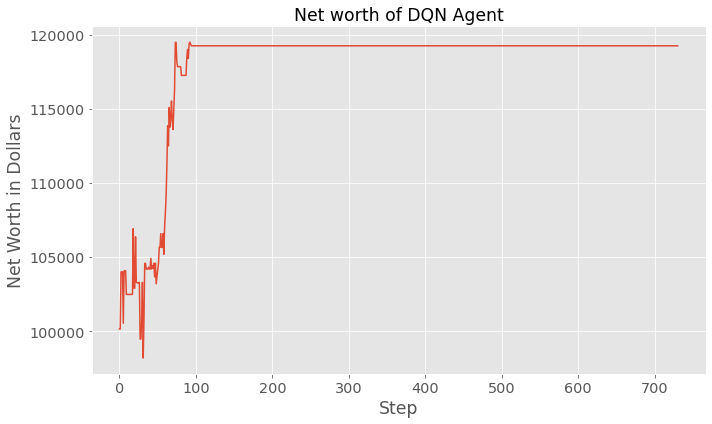

In [30]:
#Plot the networth
#dates = subset_data.index
plt.figure(figsize=(10, 6), tight_layout=True)
plt.plot(portfolio.performance.index, portfolio.performance['net_worth'], label="Net Worth")
plt.xlabel("Step")
plt.ylabel("Net Worth in Dollars")
plt.title("Net worth of DQN Agent")
plt.show()

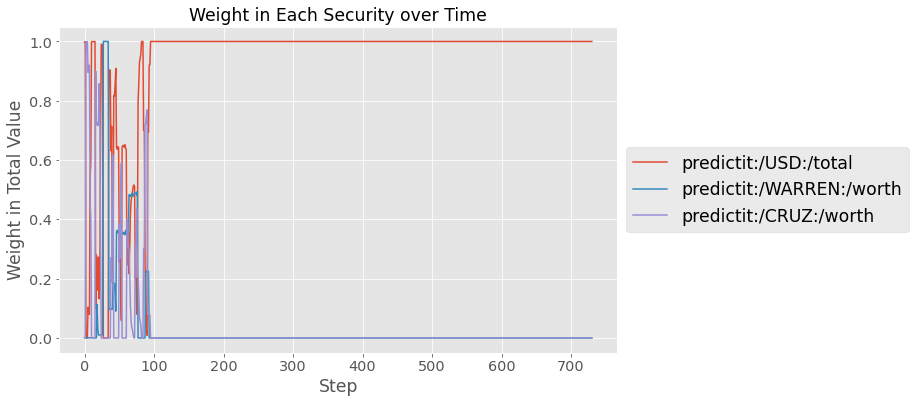

In [31]:
### Plot the total balance in each type of item
import seaborn as sns

ax = portfolio.weights.iloc[:,:].plot(figsize=(10, 6))

plt.xlabel("Step")
plt.ylabel("Weight in Total Value")
plt.title("Weight in Each Security over Time")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

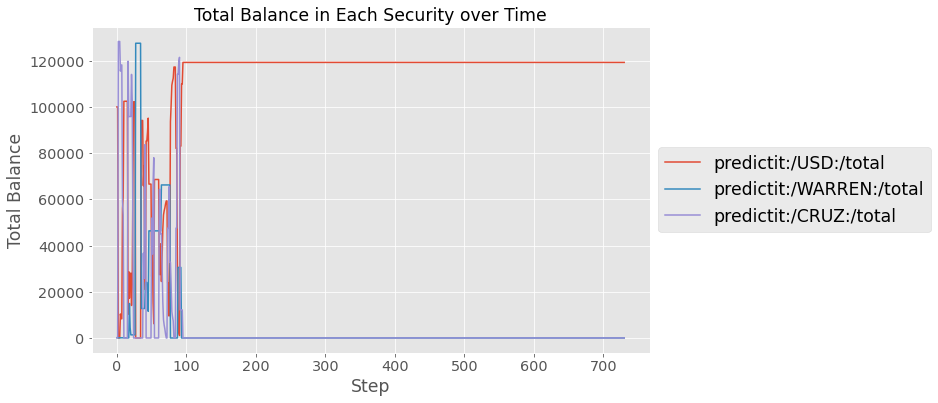

In [32]:
total_shares = portfolio.performance.loc[:, [("total" in name) for name in portfolio.performance.columns]]
total_shares.plot(figsize=(10, 6))


plt.xlabel("Step")
plt.ylabel("Total Balance")
plt.title("Total Balance in Each Security over Time")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

In [40]:
total_balances = portfolio.performance.loc[:, [("total" in name) for name in portfolio.performance.columns]]
change_df = total_balances.dropna().pct_change()
change_df = change_df.replace([np.inf, -np.inf, np.nan], 0)
change_in_balances = change_df.iloc[-1].values
total_changes = np.sum(change_in_balances)
total_changes

16.833449788478763

In [41]:
total_balances = portfolio.performance.loc[:, [("total" in name) for name in portfolio.performance.columns]]
change_df = total_balances.dropna().pct_change()
change_df = change_df.replace([np.inf, -np.inf, np.nan], 0)
change_in_balances = change_df.iloc[-1].values
change_in_balances

array([17.63344979, -0.8       ,  0.        ])

## Extra Stuff

In [ ]:
apath = "/Users/jasonfiacco/Documents/Yale/Senior/thesis/jasonfiacco-selectedmarkets-mytickers.xlsx"
df = pd.read_excel(apath, skiprows=2)
jason_tickers = df.iloc[:, 5].tolist()
descriptions = df.iloc[:, 1].tolist()

for ticker, description in zip(jason_tickers, descriptions):
    l = "{} = Instrument(\'{}\', 2, \'{}\')".format(ticker, ticker, description)
    print(l)

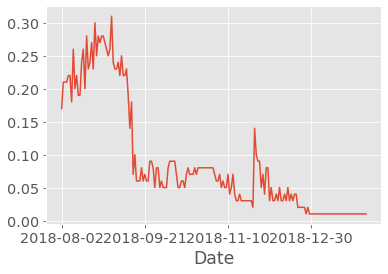

In [55]:
import matplotlib.pyplot as plt
#closing_prices = test_data.loc[:, [("price_norm" in name) for name in test_data.columns]]
my_data = all_data[(pd.to_datetime(all_data.index)>= '08-02-2018')]
my_data["MANAFORT:close"].plot()


In [ ]:
closing_prices.plot(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing prices of all markets")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

In [53]:
portfolio.performance[["predictit:/MANAFORT:/worth", "predictit:/MANAFORT:/total"]]

,predictit:/MANAFORT:/worth,predictit:/MANAFORT:/total
step,,
0,75.0,500
1,75.0,500
2,75.0,500
3,75.0,500
4,75.0,500
...,...,...
87,75.0,500
88,75.0,500
89,75.0,500
